# Tranforming and plotting bird migration coordinates as trjectories

In [18]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiLineString
import geodatasets
import matplotlib.pyplot as plt

### Defining function to convert ordered coordinates into linestrings

In [2]:
def convert_point_list_to_linestring(coord_list):
    if len(coord_list) > 0:
        if isinstance(coord_list[0], list):
            line_geom = MultiLineString(coord_list)
        else:
            line_geom = LineString(coord_list)
    else:
        line_geom = None
    return line_geom

In [3]:
birds_track_coord_data = pd.read_csv('../migratory_birds.csv')

In [27]:
birds_track_coord_data.head()

,species,birdID,date,longitude,latitude
0,Black-bellied plover,19,07/07/2017,-166.3367,64.8885
1,Black-bellied plover,19,08/07/2017,-166.3169,64.8800
2,Black-bellied plover,19,10/07/2017,-166.3270,64.8595
3,Black-bellied plover,19,10/07/2017,-166.3195,64.8677
4,Black-bellied plover,19,12/07/2017,-166.3118,64.8656


The following information is available in the data - 
1. species - bird species, categorising the collective movement by the species over the period of time.
2. birdID - identifier for the bird and data provided by individual bird
3. date - date of the observation
4. (longitude, latitude) - geographic coordinate of the bird at a given date

### Creating the trajectory map using the coodinates data without any processing

### 1. Trajectory with no coordinate tranformation

In [4]:
def create_trajectory_map_v1(df):
    df = df.copy()
    geometry_points = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    point_df = gpd.GeoDataFrame(df, geometry=geometry_points)
    point_df['date'] = pd.to_datetime(point_df['date'], format='%d/%m/%Y')
    point_df = point_df.sort_values(by=['date'])
    line_df = point_df.groupby(['species', 'birdID'])['geometry'].apply(list).reset_index()
    line_df['geometry'] = line_df['geometry'].apply(lambda x:convert_point_list_to_linestring(x))
    trajectory_line_geom_df = gpd.GeoDataFrame(line_df, geometry='geometry',crs='EPSG:4326')
    return trajectory_line_geom_df

In [6]:
bird_trjectory_df_v1 = create_trajectory_map_v1(birds_track_coord_data)

In [19]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

Text(0.5, 1.0, 'Trajectory Map V1')

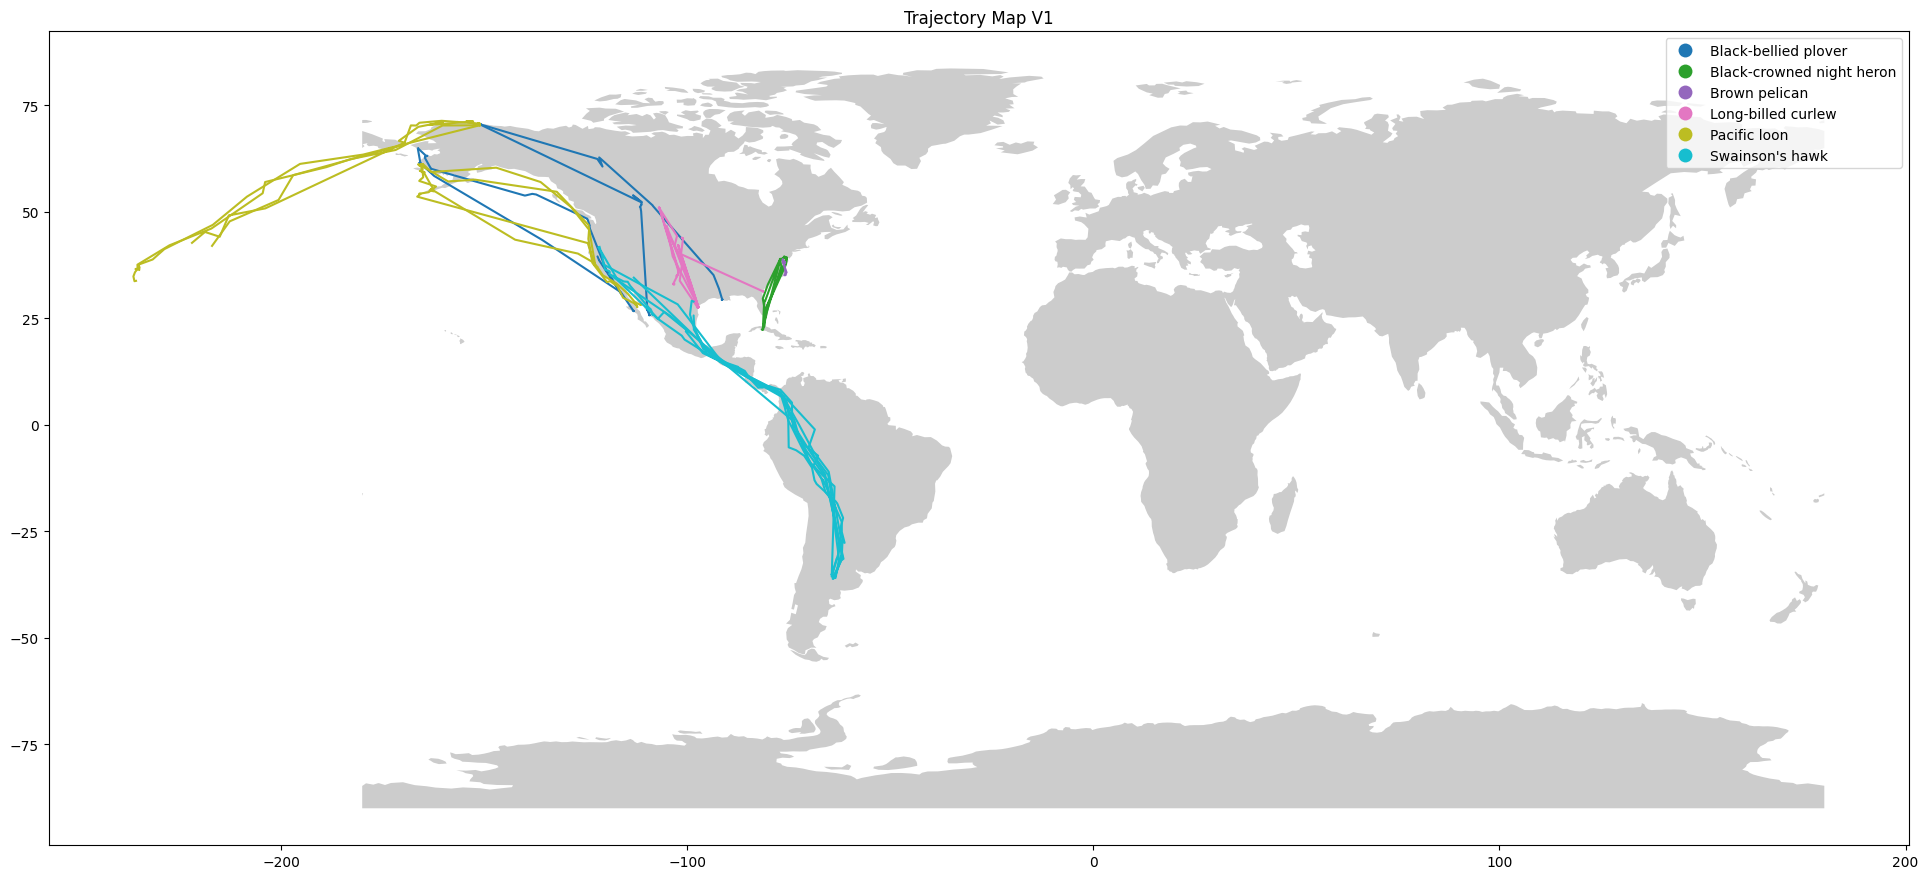

In [21]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
bird_trjectory_df_v1.plot(column="species", ax=ax, legend=True)
plt.title("Trajectory Map V1")

### Analysis of map version 1

trajectory from **pacific loon** are going out from the map extent on the left. The reason is the value of logitude in those cases is less that -180. We cannot find out from this origin or the destination of this species i.e. the geographic context is missing.

In [80]:
bird_trjectory_df_v1.to_file('../migratory_birds_trajectory_v1.geojson', driver='GeoJSON')

### 2. Trajectory with coordinate tranformation (less than -180 moved to the eastern hemisphere)

In [10]:
def create_trajectory_map_v2(df):
    df = df.copy()
    df['longitude'] = df['longitude'].apply(lambda x:x+360 if x < -180 else x)
    geometry_points = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    point_df = gpd.GeoDataFrame(df, geometry=geometry_points)
    point_df['date'] = pd.to_datetime(point_df['date'], format='%d/%m/%Y')
    point_df = point_df.sort_values(by=['date'])
    line_df = point_df.groupby(['species', 'birdID'])['geometry'].apply(list).reset_index()
    line_df['geometry'] = line_df['geometry'].apply(lambda x:convert_point_list_to_linestring(x))
    trajectory_line_geom_df = gpd.GeoDataFrame(line_df, geometry='geometry', crs='EPSG:4326')
    return trajectory_line_geom_df


In [22]:
bird_trjectory_df_v2 = create_trajectory_map_v2(birds_track_coord_data)

Text(0.5, 1.0, 'Trajectory Map V2')

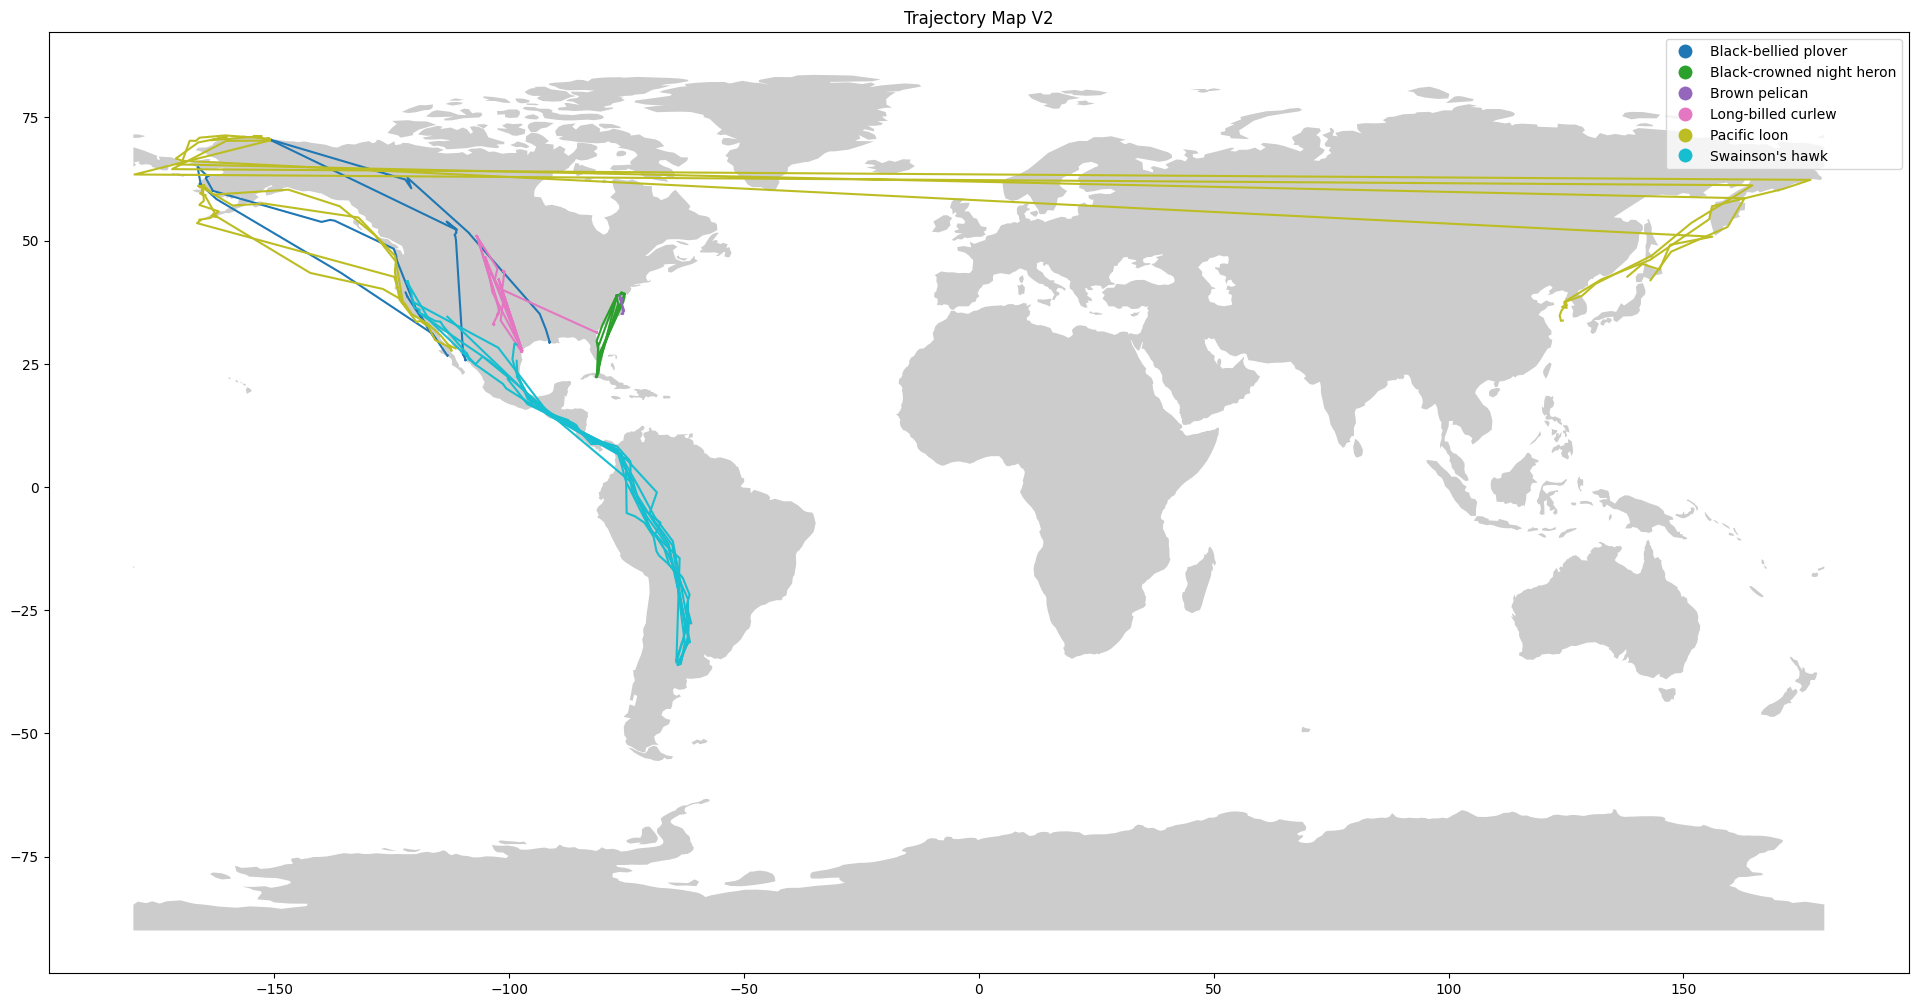

In [23]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
bird_trjectory_df_v2.plot(column="species", ax=ax, legend=True)
plt.title("Trajectory Map V2")

### Analysis of map version 2

Now the coordinates which are not in the legitimate logitude range and converted into correct values using the tranformation. But the issue comes in the trajectory as it does not represent the correct movement of birds. birds seems to fly across the world from western to eastern hemisphere. 

In [ ]:
bird_trjectory_df_v2.to_file('../migratory_birds_trajectory_v2.geojson', driver='GeoJSON')

### 3. Trajectory with coordination tranformation and making trajectory multipart

In [24]:
def create_trajectory_map_v3(df):
    df = df.copy()
    df['multiline'] = df['longitude'].apply(lambda x:2 if x < -180 else 1)
    df['longitude'] = df['longitude'].apply(lambda x:x+360 if x < -180 else x)
    geometry_points = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    point_df = gpd.GeoDataFrame(df, geometry=geometry_points)
    point_df['date'] = pd.to_datetime(point_df['date'], format='%d/%m/%Y')
    point_df = point_df.sort_values(by=['date'])
    line_df = point_df.groupby(['species', 'birdID', 'multiline'])['geometry'].apply(list).reset_index()
    line_df2 = line_df.groupby(['species', 'birdID'])['geometry'].apply(list).reset_index()
    line_df2['geometry'] = line_df2['geometry'].apply(lambda x:convert_point_list_to_linestring(x))
    trajectory_line_geom_df = gpd.GeoDataFrame(line_df2, geometry='geometry', crs='EPSG:4326')
    return trajectory_line_geom_df


In [25]:
bird_trjectory_df_v3 = create_trajectory_map_v3(birds_track_coord_data)

Text(0.5, 1.0, 'Trajectory Map V3')

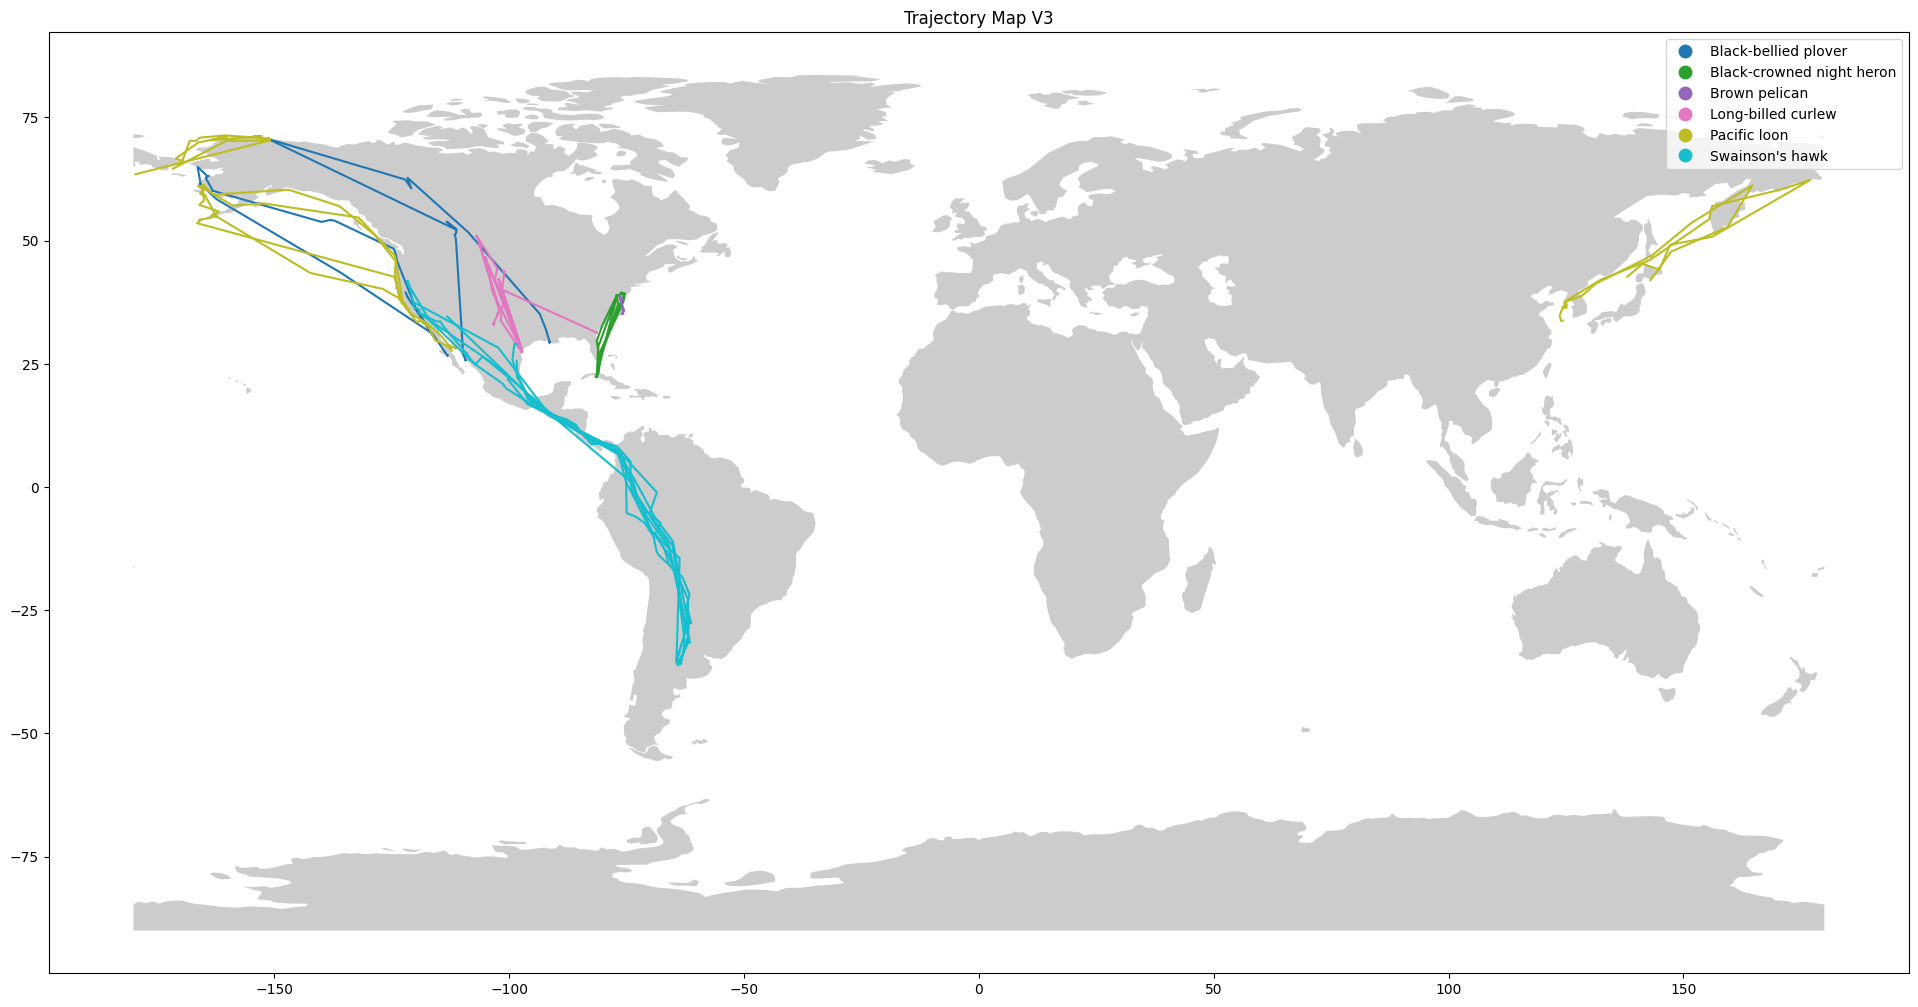

In [26]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
bird_trjectory_df_v3.plot(column="species", ax=ax, legend=True)
plt.title("Trajectory Map V3")

### Analysis of map version 3

The trajectory on the western hemisphere are correctly mapped with respect to the geographic reference and same is the case on the eastern hemisphere. The discontinuity of the trjectory lines is there but still this map makes more sense with respect to undertanding the movement, source and destination of the migration.  

In [ ]:
bird_trjectory_df_v3.to_file('../migratory_birds_trajectory_v3.geojson', driver='GeoJSON')